This notebook executes model files (.inp) and loops through the different input parameters (geometry, slope, area) and soil types. For each scenario, two simulations are run: (1) impervious routed to pervious; (2) pervious only. IF is computed as the fraction of runon to pervious that infiltrates.

**Note that this requires .inp files with the following format:**
1. pervious soil parameters @ line 69 of the input file (see "perm_line" variable; this can be updated to match your input file)
2. two .inp files for each P scenario, titled as follows: 'P_X.0in_WRITE.inp' and 'P_X.0in_READ.inp' where X = P



In [1]:
import seaborn as sns
import itertools 
import numpy as np;
import pandas as pd;
import os,sys
import matplotlib.pyplot as plt;
import pickle

from pyswmm import Simulation;
from pyswmm import Subcatchments;
from pyswmm import Nodes;
from pyswmm import SystemStats;
from pyswmm import Simulation;
from swmmtoolbox import swmmtoolbox;
from itertools import combinations
from os.path import dirname

parent_dir = (dirname(os.getcwd()))
sys.path.append("\\".join([parent_dir, 'model']) )
current_dir = (os.getcwd())


import functions
from functions import *

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# input parameters
Enter input parameters: 
- antecedent soil moisture conditions ("SAT","FC", "WP")
- precipitation depth (inches) (0.6, 1., 2., 3., 4.)



In [2]:
# # precip and ASM conditions
# WP done
# FC done

P = 0.6
ASM = 'SAT'

In [3]:
#open params and soil pickles

with open('params_2.pickle', 'rb') as handle:
    params = pickle.load(handle)
    params_df = pd.DataFrame(params)
with open('soil.pickle', 'rb') as handle:
    soil = pickle.load(handle)

In [4]:
# set paths (write and read inp files, out folder)
write_path,read_path,out_path,run=paths(P,ASM,current_dir)
#select subset of soil df based on ASM
soil_dum = soil[soil.Cond ==ASM]

In [5]:
# test simulation on write path
test_sim(write_path)

{'drains': 0.0, 'evaporation': 0.0, 'final_snow_cover': 0.0, 'final_storage': 0.0, 'infiltration': 12466.311947226688, 'init_snow_cover': 0.0, 'init_storage': 0.0, 'routing_error': 0.0, 'rainfall': 0.6000000000000011, 'runoff': 337.0304391777163, 'runon': 0.0, 'snow_removed': 0.0}


# Run model

In [6]:
perm_line = 69

K=soil_dum["K"][1] #    pulls the K value from soil dictionary
H_i=soil_dum["H_i"][1] #    suction head
IMD=soil_dum["IMD"][1] #    initial moisture deficit
Cond=soil_dum["Cond"][1]
with open(read_path) as f:
    for i, line in enumerate(f, 1):
        if i ==69:
            break
print(line)

update_GA(read_path,write_path, perm_line,H_i,K,IMD)
with open(write_path) as f:
    for i, line in enumerate(f, 1):
        if i ==69:
            break
print(line)

S2              	12.6      	0.01      	0.097     

S2              	2.4      	1.18      	0.0



In [150]:
#run sim for impervious to pervious

perm_line = 69
data1=dict()
j=len(soil_dum)
g=dict()
data=pd.DataFrame()
data2df=pd.DataFrame()

for index, row in params_df.iterrows():
#     print((index)/len(params_df))
    
    data2df=data2df
    A1=row['A1']
    A2=row['A2']
    S=row['S']
    W=row['W']
        
    for i in range(j):
        K=soil_dum["K"][i] #    pulls the K value from soil dictionary
        H_i=soil_dum["H_i"][i] #    suction head
        IMD=soil_dum["IMD"][i] #    initial moisture deficit
    
        update_GA(read_path, write_path, perm_line,H_i,K,IMD)
    
        infiltration,runoff,runon=run_sim(write_path,A1,A2,W,W,S,P)

        infiltration_perv,runoff_perv,runon_perv=run_sim(write_path,0,A2,W,W,S,P)
        
        data.set_value(i,'infiltration',infiltration)
        data.set_value(i,'runoff',runoff)
        data.set_value(i,'runon',runon)
        data.set_value(i,'infiltration_perv',infiltration_perv)
        data.set_value(i,'runoff_perv',runoff_perv)
        data.set_value(i,'runon_perv',runon_perv)

        data.set_value(i,'param',index)
        data.set_value(i,'A1',A1)
        data.set_value(i,'A2',A2)
        data.set_value(i,'W',W)
        data.set_value(i,'S',S)
        data.set_value(i,'ASM',ASM)
        data.set_value(i,'P',P)
        data.set_value(i,'H_i',H_i)
        data.set_value(i,'Ks',K)
        data.set_value(i,'IMD',IMD)
        data.set_value(i,'soil',i)
        data1.update(data)   
        
    data1df=pd.DataFrame(data1)
    frames1=[data1df,data2df]
    data2df=pd.concat(frames1)    


with open('out/'+str(run)+'.pickle', 'wb') as handle:
    pickle.dump(data2df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
core_temp=data2df.reset_index().drop(['index'], axis=1)
core_temp['A']=core_temp['A2']+core_temp['A1']
core_temp['fV']=core_temp['A2']/core_temp['A']

for index,row in core_temp.iterrows():
    string = 'P='+str(row['P'])+'/'+'param='+str(row['param'])+'/'+'ASM='+str(row['ASM'])+'/'+'soil='+str(row['Ks'])
    core_temp.set_value(index,'uniqueID',string)

core_temp['delta_inf']=core_temp['infiltration']-core_temp['infiltration_perv']
core_temp['IF']=core_temp['delta_inf']/(core_temp['runon'])
core_temp.sort_values('IF').head()

NameError: name 'data2df' is not defined

Text(0.5, 1, 'IF across range of pervious fractions')

<Figure size 720x576 with 0 Axes>

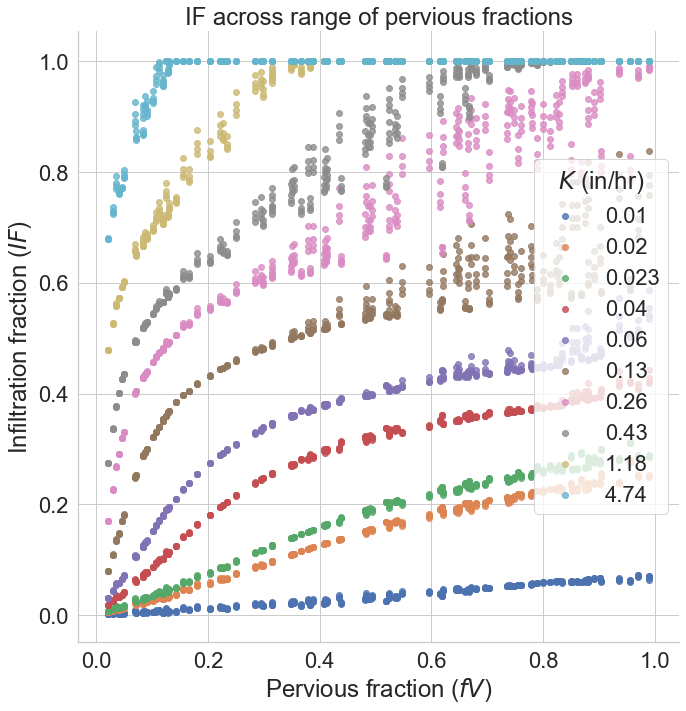

In [152]:
#plot

sns.set(color_codes=True)
sns.set(font_scale=2)  
plt.figure(1, figsize=(10,8), )
sns.set_context("talk",rc={"lines.linewidth": 2.5})
sns.set(style="whitegrid", font_scale=2,rc={'figure.figsize':(12,8)})
sns.lmplot( x="fV", y="IF", data=core_temp, fit_reg=False, hue='Ks', logx =False, height = 10, legend= False)

plt.legend(title = '$K$ (in/hr)', loc = 'best')
plt.xlabel('Pervious fraction ($fV$)')

plt.ylabel('Infiltration fraction ($IF$)')
plt.title("IF across range of pervious fractions")

In [153]:
data2df

,infiltration,runoff,runon,infiltration_perv,runoff_perv,runon_perv,param,A1,A2,W,S,ASM,P,H_i,Ks,IMD,soil
0,1191.365333,0.000000,281.634031,909.731569,0.000000,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,1.93,4.740,0.0,0.0
1,1191.365333,0.000000,281.634031,909.731569,0.000000,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,2.40,1.180,0.0,1.0
2,1189.636160,2.830758,281.634031,909.731569,0.000000,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,4.33,0.430,0.0,2.0
3,1047.512818,147.027989,281.634031,872.947376,38.098084,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,3.50,0.130,0.0,3.0
4,1159.172248,33.813699,281.634031,908.739225,1.674745,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,6.69,0.260,0.0,4.0
5,906.726772,287.615911,281.634031,782.128918,129.756191,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,8.66,0.060,0.0,5.0
6,826.019256,368.807659,281.634031,722.640553,189.023882,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,10.63,0.040,0.0,6.0
7,707.227240,487.471778,281.634031,637.026898,275.090225,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,9.45,0.023,0.0,7.0
8,674.549353,519.959990,281.634031,614.086051,298.208074,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,11.42,0.020,0.0,8.0
9,501.907365,691.914972,281.634031,486.868689,425.192842,0.0,99.0,0.140433,0.417676,86.380413,4.0,SAT,0.6,12.60,0.010,0.0,9.0
